# Products Clustering

Através da coluna **Description** será criado um _Bag of Words_ sobre todos os tipos de produtos presentes no dataset. O objetivo deste experimento é fazer uma Clusterização que separe produtos em várias categorias, através de sua descrição.

Importando blibliotecas.

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk as nltk
%matplotlib inline

Lendo _dataset_ já pré processado.

In [54]:
df = pd.read_csv('data/final_online_retail.csv')

Mostrando os cabeçalhos e os 5 primeiros registros.

In [55]:
df.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderCanceled
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


Pegando os dados da coluna **Description** para iniciar o tratamento de seu conteúdo.

In [56]:
products = df['Description']

Regex para retirar números e caracteres especiais de cada descrição de produto.

In [57]:
products = products.str.replace(r'[^a-zA-Z0-9 ]', '')

Iniciando um **Porter stemmer**, que é um Stemizador que tira afixos das palavras. Este é uma coleção de regras que refletem como o **inglês** lida com inflexões.

Ex.:
apple, apples => appl
berry, berries => berri

In [58]:
ps = nltk.stem.PorterStemmer()

Criando um método que aplica o _stem_ em toda a String passada por parâmetro.

In [59]:
def stem_product(product):
    words = nltk.word_tokenize(product)
    separated_words = []
    for w in words:
        separated_words.append(ps.stem(w))
    return ' '.join(separated_words)

Aplicando o método criado anteriormente para todos os registros da coluna **Description**.

In [60]:
stem_products = products.apply(lambda p: stem_product(p))

Para criar o _Bag of Words_, foi escolhido o modelo **TFIDFVectorizer**, o valor aumenta proporcinalmente à contagem de palavras, mas tem um offset de acordo com a frequência das mesmas.

df(t,D)=logN/|d∈D:t∈d|

N: número de palavras
|d∈D:t∈d| : número de documentos que a palavra t aparece

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word', tokenizer=nltk.word_tokenize, preprocessor=None, token_pattern=None)

No _fit transform_ acontece o processo de aprendizado do vocabulário, que no caso foi a coluna de descrições que contém as palavras. No fim é gerada uma matriz esparsa que contém a occorência das palavras em cada produto.

In [62]:
bag_of_words = vectorizer.fit_transform(stem_products)
bag_of_words

<401604x1908 sparse matrix of type '<class 'numpy.float64'>'
	with 1752900 stored elements in Compressed Sparse Row format>

Verificando a lista de palavras geradas pelo método de _feature extraction_. Nota-se que as palavras geradas contém apenas o radical das palavras.

In [63]:
vectorizer.get_feature_names()[120:130]

['babushka',
 'back',
 'backpack',
 'bad',
 'badg',
 'bag',
 'bain',
 'bake',
 'bakelik',
 'baker']

Contando quantas palavras foram geradas a partir do _count vectorizer_

In [64]:
print('Foram geradas', len(vectorizer.get_feature_names()), 'palavras da coluna Description')

Foram geradas 1908 palavras da coluna Description


Gerando uma lista de tuplas ordenada, contendo a quantidade de ocorrências de cada palavra na descrição dos produtos.

In [65]:
words_occurrence = sorted(zip(bag_of_words.toarray().sum(axis=0), vectorizer.get_feature_names()), reverse=True)

Visão preliminar do _zip_ criado.

In [66]:
words_occurrence[:10]

[(14091.62422244993, 'bag'),
 (11404.603553534022, 'red'),
 (11300.788664407071, 'of'),
 (11194.928545596777, 'heart'),
 (11191.862913908357, 'set'),
 (10357.244717864918, 'retrospot'),
 (9088.48765972901, 'vintag'),
 (8698.646115451833, 'design'),
 (7471.504038267527, 'pink'),
 (7410.930898774365, 'jumbo')]

Criando um _data frame_ com o número de ocorrência para plotar no gráfico.

In [67]:
word_count = pd.DataFrame(words_occurrence, columns=['count', 'word'])
word_count.head()

,count,word
0,14091.624222,bag
1,11404.603554,red
2,11300.788664,of
3,11194.928546,heart
4,11191.862914,set


Plotando o gráfico que mostra a quantiade de ocorrências das 100 palavras mais recorrentes.

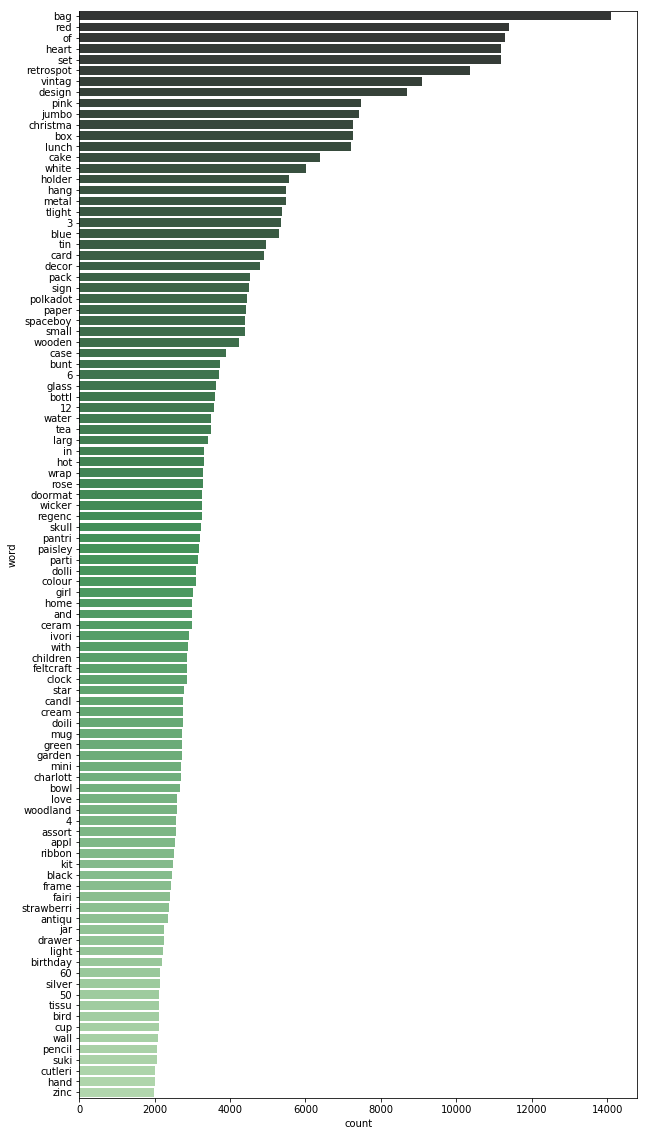

In [68]:
plt.figure(figsize=(10, 20))
sns.barplot(y='word', x='count', data=word_count[:100], palette='Greens_d')

Clusterizando o _bag of words_ utilizando o **KMeans**, que tem o objetivo de particionar as observações (neste caso, as palavras) dentre os espaços definidos (número de clusters, que no caso são categorias de produtos) onde cada observação pertence ao grupo mais próximo da média.

Foi escolhido o método de inicialização padrão do KMeans (k-means++), que seleciona os centros dos clusters para o k-mean clustering de maneira rápida para aumentar a convergencia. Otras opções seriam 'random' e 'array'.

In [69]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='random', n_clusters=5, algorithm="full")
km = kmeans.fit(bag_of_words)
clusters = kmeans.predict(bag_of_words)

Mostrando a quantidade de produtos que convergiu para cada cluster.

In [70]:
cluster_number = [3, 2, 1, 0, 4]
for index, cluster in enumerate(list(pd.Series(clusters).value_counts())):
    print('Cluster', cluster_number[index], ':', cluster, 'produtos')

Cluster 3 : 284979 produtos
Cluster 2 : 45021 produtos
Cluster 1 : 33648 produtos
Cluster 0 : 24985 produtos
Cluster 4 : 12971 produtos


Adicionando a coluna da classificação da clusterização ao _data frame_.

In [71]:
df['Description'] = stem_products
df_classified = df
df_classified['Category'] = pd.DataFrame(clusters, columns=['cluster'])
df_classified.head(10)

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderCanceled,Category
0,0,536365,85123A,white hang heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,4
1,1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0
2,2,536365,84406B,cream cupid heart coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0
3,3,536365,84029G,knit union flag hot water bottl,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0
4,4,536365,84029E,red woolli hotti white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0
5,5,536365,22752,set 7 babushka nest box,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,0,0
6,6,536365,21730,glass star frost tlight holder,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,0,4
7,7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,0,0
8,8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,0,0
9,9,536367,84879,assort colour bird ornament,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,0,0


Dividindo o _data frame_ de acordo com a categoria classificada pela clusterização.

In [72]:
cluster_0 = df_classified.loc[df_classified['Category'] == 0]
cluster_1 = df_classified.loc[df_classified['Category'] == 1]
cluster_2 = df_classified.loc[df_classified['Category'] == 2]
cluster_3 = df_classified.loc[df_classified['Category'] == 3]
cluster_4 = df_classified.loc[df_classified['Category'] == 4]

Criando método para criar dicionário contendo o número de ocorrência das palavras em cada cluster.

In [73]:
def word_count_zip(products):
    cv = TfidfVectorizer(analyzer='word', tokenizer=nltk.word_tokenize, preprocessor=None, token_pattern=None)
    cv_fit = cv.fit_transform(products)
    wo = dict(sorted(zip(cv.get_feature_names(), cv_fit.toarray().sum(axis=0)), reverse=True))
    return wo

Aplicando o método em cada cluster e tranformando-os em um array de dicionários com a contagem nos clusters.

In [74]:
wc_cluster_0 = word_count_zip(cluster_0['Description'])
wc_cluster_1 = word_count_zip(cluster_1['Description'])
wc_cluster_2 = word_count_zip(cluster_2['Description'])
wc_cluster_3 = word_count_zip(cluster_3['Description'])
wc_cluster_4 = word_count_zip(cluster_4['Description'])
wc_clusters = [wc_cluster_0, wc_cluster_1, wc_cluster_2, wc_cluster_3, wc_cluster_4]

Plotando as palavras presentes cada cluster em Word Clouds, que, quanto maior o tamanho, maior a sua frequência.

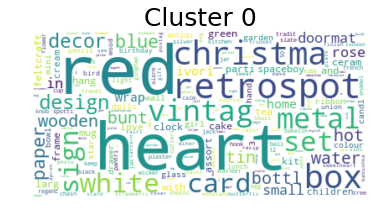

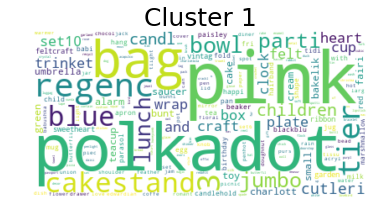

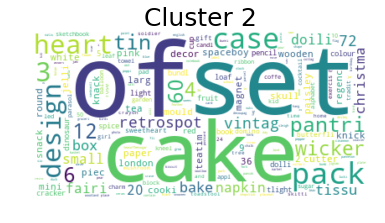

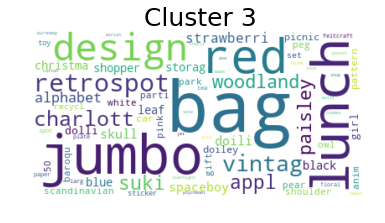

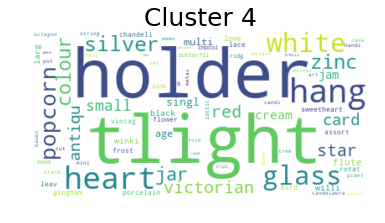

In [75]:
from wordcloud import WordCloud

for index, wc_cluster in enumerate(wc_clusters):
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(frequencies=wc_cluster)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Cluster {}'.format(index), color='black',fontsize = 25)
    plt.axis('off')
    plt.show()

### Analisando a escolha do número de Clusters

Foram escolhidos alguns métodos para avaliar se a escolha de 5 clusters foi eficaz ou poderia ter sido melhor. São eles:

- **Método de Elbow:** Analisa o valor do erro quadrático entre os clusters (representado pela inércia no sklearn). 

In [ ]:
inertias = []
centers = []

interval = range(1, 15)
for i in interval:
    k = KMeans(init='k-means++', n_clusters=i)
    k.fit(bag_of_words)
    inertias.append(k.inertia_)

plt.figure(figsize=(10, 7))
plt.plot(interval, inertias, color='green', marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.show()

- **Calinski**: Analisa a dispersão média entre os clusters e quanto maior o seu valor melhor.

In [ ]:
from sklearn.metrics import calinski_harabaz_score

cals = []

interval = range(1, 2)
for i in interval:
    k = KMeans(init='k-means++', n_clusters=i)
    k.fit(df['Description'])
    cals.append(calinski_harabaz_score(df['Description'], k.labels_))

plt.figure(figsize=(10, 7))
plt.plot(interval, cals, color='green', marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Calinski')
plt.show()

- **Silhouette Score**: É aplicada a fórmula (B - A) / max(A, B), onde: A = Distância média entre um ponto e os outros da mesma classe. B = Distância média entre um ponto e os outros da classe mais próxima. O resultado está entre -1 e 1, onde quanto mais próximo de 1 este resultado for, o coeficiente é muito bom enquanto mais perto de -1 ele é muito ruim.

In [ ]:
from sklearn.metrics import silhouette_score

silhs = []

interval = range(1, 2)
for i in interval:
    k = KMeans(init='k-means++', n_clusters=i)
    k.fit(df[])
    silhs.append(silhouette_score(bag_of_words, k.labels_))

plt.figure(figsize=(10, 7))
plt.plot(interval, cals, color='green', marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Sillouette')
plt.show()

In [ ]:
kmeans.labels_